In [8]:
import xarray as xr

import numpy as np
import pandas as pd
from pathlib import Path

import os, sys
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
#import seaborn as sns
#sns.set_style('ticks')

from scipy import stats
from scipy.stats import percentileofscore

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
#from sklearn.datasets import fetch_california_housing

Do an initial test of the multilinear regression for non tidal residuals for Monterey bay 

In [4]:
ntr=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/utide.residuals.montereybay.1996.2021.csv")
ntr #the variable "Residual" is what we want it is calculated by subtracting from utide predicted tide, see notebook global/scratch/users/jennaisrael/climate_data_processing/sl_regression/detrended_residuals_utide.ipynb

,Date Time,Date Time.1,Water Level,Sigma,O or I (for verified),F,R,L,Quality,flag,elev,interp,detrend,anomaly,Residual,Predicted Tide
0,1995-12-31 16:00:00,1995-12-31 16:00:00,0.389,0.107,0,0,0,0,v,0.0,0.389,0.389,-0.490776,-0.490776,-0.041856,-0.448920
1,1995-12-31 16:06:00,1995-12-31 16:06:00,0.381,0.130,0,0,0,0,v,0.0,0.381,0.381,-0.498776,-0.498776,-0.072251,-0.426526
2,1995-12-31 16:12:00,1995-12-31 16:12:00,0.471,0.154,0,0,0,0,v,0.0,0.471,0.471,-0.408776,-0.408776,-0.004962,-0.403814
3,1995-12-31 16:18:00,1995-12-31 16:18:00,0.494,0.113,0,0,0,0,v,0.0,0.494,0.494,-0.385776,-0.385776,-0.004932,-0.380844
4,1995-12-31 16:24:00,1995-12-31 16:24:00,0.474,0.088,0,0,0,0,v,0.0,0.474,0.474,-0.405776,-0.405776,-0.048102,-0.357674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257515,2021-10-01 23:30:00,2021-10-01 23:30:00,0.423,0.076,0,0,0,0,v,0.0,0.423,0.423,-0.538693,-0.538693,-0.008114,-0.530580
2257516,2021-10-01 23:36:00,2021-10-01 23:36:00,0.378,0.122,0,0,0,0,v,0.0,0.378,0.378,-0.583693,-0.583693,-0.028816,-0.554877
2257517,2021-10-01 23:42:00,2021-10-01 23:42:00,0.375,0.083,0,0,0,0,v,0.0,0.375,0.375,-0.586693,-0.586693,-0.008441,-0.578252
2257518,2021-10-01 23:48:00,2021-10-01 23:48:00,0.333,0.084,0,0,0,0,v,0.0,0.333,0.333,-0.628694,-0.628694,-0.028038,-0.600655


Variables we will use in the regression: sea-level pressure (PSL), windstress from u, windstress from v, ENSO index, PDO index, air temperature (if I can pick an on land location that is close enough, masked out for the ocean)

In [16]:
#now compare with Sam's residuals
mb_sam=pd.read_fwf("/global/scratch/users/jennaisrael/time_varying_data/slr_data_sam/data4regrbuild.daily.era5.monterey.norm0.txt")
mb_sam.columns=["Year", "Month", "Day", "ResWL_lo", "ResWL_hi", "SLPa", "TASa", "N34a", "PDOa", "U10a", "V10a"]
mb_sam["date"]=pd.to_datetime(mb_sam[['Year', 'Month', 'Day']])
#datetime seems to be causing an issue leave it from the index for now
#mb_sam.index=mb_sam["date"]
mb_sam["ResWL_total"]=mb_sam["ResWL_hi"]+mb_sam["ResWL_lo"]
mb_sam

,Year,Month,Day,ResWL_lo,ResWL_hi,SLPa,TASa,N34a,PDOa,U10a,V10a,date,ResWL_total
0,1973,11,12,-0.02788,0.05941,-2.01526,1.15286,-2.07505,-1.28235,0.58345,62.36506,1973-11-12,0.03153
1,1973,11,13,-0.02278,0.01739,0.51379,0.14197,-2.08711,-1.28528,-10.66715,35.28530,1973-11-13,-0.00539
2,1973,11,14,-0.01262,-0.03827,2.04980,0.37289,-2.09914,-1.28824,-9.67575,30.52757,1973-11-14,-0.05089
3,1973,11,15,-0.00850,-0.06106,2.26141,0.08441,-2.11116,-1.29122,-12.71806,30.81868,1973-11-15,-0.06956
4,1973,11,16,-0.02547,0.00956,-3.54065,0.87811,-2.11025,-1.27463,-8.62905,67.52818,1973-11-16,-0.01591
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17092,2020,12,27,-0.00009,0.01417,-1.68414,-1.22424,-1.32486,-0.91245,-1.72206,2.64090,2020-12-27,0.01408
17093,2020,12,28,0.00145,0.13299,-12.65814,-1.16611,-1.32366,-0.91397,9.90384,20.82512,2020-12-28,0.13444
17094,2020,12,29,0.00355,0.00568,0.04828,-0.54269,-1.32248,-0.91541,10.16266,-30.99345,2020-12-29,0.00923
17095,2020,12,30,0.00470,-0.07551,7.64056,-0.49118,-1.32132,-0.91676,2.84751,-3.36609,2020-12-30,-0.07081


Make a new dataframe replacing Sam's residual with mine, trimming to have the same start and end date 
This also requires resampling my residuals to be daily (ultimately they should be hourly)


for now just practice setting up the multilinear regression and doing train test split

In [21]:
X = mb_sam[["SLPa","TASa","N34a","U10a","V10a"]] #also leave date out for now
y = mb_sam["ResWL_total"]

In [22]:
X

,SLPa,TASa,N34a,U10a,V10a
0,-2.01526,1.15286,-2.07505,0.58345,62.36506
1,0.51379,0.14197,-2.08711,-10.66715,35.28530
2,2.04980,0.37289,-2.09914,-9.67575,30.52757
3,2.26141,0.08441,-2.11116,-12.71806,30.81868
4,-3.54065,0.87811,-2.11025,-8.62905,67.52818
...,...,...,...,...,...
17092,-1.68414,-1.22424,-1.32486,-1.72206,2.64090
17093,-12.65814,-1.16611,-1.32366,9.90384,20.82512
17094,0.04828,-0.54269,-1.32248,10.16266,-30.99345
17095,7.64056,-0.49118,-1.32132,2.84751,-3.36609


Try a simple single chronological train test split for now

In [23]:
X_train, X_test= np.split(X, [int(.67 *len(X))])
y_train, y_test= np.split(y, [int(.67 *len(X))])

/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/global/home/users/jennaisrael/.conda/envs/geoplot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [24]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred = model.predict(X_test)

In [33]:
y_test_plot

,index,ResWL_total
0,11454,-0.00306
1,11455,-0.01923
2,11456,-0.03399
3,11457,-0.03741
4,11458,-0.02662
...,...,...
5638,17092,0.01408
5639,17093,0.13444
5640,17094,0.00923
5641,17095,-0.07081


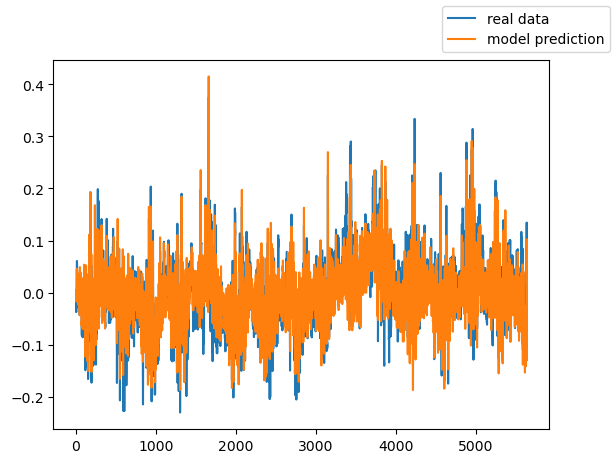

In [34]:
y_test_plot=y_test.reset_index() #so when I plot they appear on top of eachother

fig, ax =plt.subplots()

ax.plot(y_test_plot.ResWL_total,label='real data')
ax.plot(y_pred,label='model prediction')
fig.legend()

In [36]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.0014020667440802622

In [38]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.029818487200237612

In [3]:
test=xr.open_dataset("/global/scratch/users/jennaisrael/time_varying_data/test_cirrus/noaa_stdmet_46012_1996.nc")
test

ERROR 1: PROJ: proj_create_from_database: Open of /global/home/users/jennaisrael/.conda/envs/geoplot/share/proj failed


<xarray.Dataset> Size: 668kB
Dimensions:                  (time: 8784, latitude: 1, longitude: 1)
Coordinates:
  * time                     (time) datetime64[ns] 70kB 1996-01-01 ... 1996-1...
  * latitude                 (latitude) float32 4B 37.36
  * longitude                (longitude) float32 4B -122.9
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 70kB ...
    wind_spd                 (time, latitude, longitude) float32 35kB ...
    gust                     (time, latitude, longitude) float32 35kB ...
    wave_height              (time, latitude, longitude) float32 35kB ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] 70kB ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] 70kB ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 35kB ...
    air_temperature          (time, latitude, longitude) float32 35kB ...
    sea_surface_temperature  (time, latitude, longitude) float32 35kB ...
    dewpt_temperature        (time, latitude, longitude) float32 35kB ...
    visibility               (time, latitude, longitude) float32 35kB ...
    water_level              (time, latitude, longitude) float32 35kB ...

test data seems to be from a buoy in the pacific ocean https://www.ndbc.noaa.gov/station_page.php?station=46012, could be good for windstress?